# Overview

The data set with goal timings and the data set with odds(prices) now have a common key: the `event id`.  
We can therefore process Betfair data files for relevant matches and get minute-by-minute odds(prices) in tabular form.  

Objective:  
- get minute-by-minute odds(prices) in tabular form.  
- process the tabular data, perform relevant calculations and a sanity check.

# Setup

## Imports

In [356]:
# data wrangling
import json
import numpy as np
import pandas as pd
# files, system
import os
# compressed files
import bz2
# processing time
from tqdm import tqdm
# graphs
import matplotlib.pyplot as plt

# Parse data files

## Functions to parse one file

Function to get a list of dictionaries from original `.bz2` file.

In [357]:
def bz2_to_dict_list(bz2_file_path):
    """
    Converts a .bz2 file to a list of dictionaries.
    
    Args:
        bz2_file_path (str): Path to the .bz2 file.
    
    Returns:
        list of dict: List of dictionaries represented by the .bz2 file.
    """
    with bz2.BZ2File(bz2_file_path, "rb") as bz2_file:
        data = bz2_file.read().decode("utf-8")
        data_list = []
        for line in data.splitlines():
            data_list.append(json.loads(line))
    return(data_list)

In [358]:
EVENT_INFO_INDEX = 0
MC_INDEX = 0
HOME_TEAM_INDEX = 0
AWAY_TEAM_INDEX = 1
THE_DRAW_INDEX = 2

def normalize_odds_data(data):
    """
    Extracts data on: event id, timestamp, in-play status, and last traded prices (ltp),
    and returns pandas DataFrame.
    
    Args:
        data(list of dictionaries): parsed from a Betfair data file.
        
    Returns:
        DataFrame with event id, timestamp, in-play status, and last traded prices (ltp).
    """
    
    data_market_definition = data[EVENT_INFO_INDEX]['mc'][MC_INDEX]['marketDefinition']
    event_id = data_market_definition['eventId']
    id_home = data_market_definition['runners'][HOME_TEAM_INDEX]['id']
    id_away = data_market_definition['runners'][AWAY_TEAM_INDEX]['id']
    id_draw = data_market_definition['runners'][THE_DRAW_INDEX]['id']
    
    ids = {}
    ids['home'] = id_home
    ids['away'] = id_away
    ids['draw'] = id_draw
    pt = []
    in_play = []
    ltp = {}
    ltp['home'] = []
    ltp['away'] = []
    ltp['draw'] = []

    for record in data:
        pt.append(record['pt'])
        if ('marketDefinition' in record['mc'][MC_INDEX]) and ('inPlay' in record['mc'][MC_INDEX]['marketDefinition']):
            in_play.append(record['mc'][MC_INDEX]['marketDefinition']['inPlay'])
        else:
            in_play.append(np.nan)

        if 'rc' in record['mc'][MC_INDEX]:
            d_rc = {d['id']: d['ltp'] for d in record['mc'][MC_INDEX]['rc']}
        else:
            d_rc = {}
        for team in ['home', 'away', 'draw']:
            if ids[team] in d_rc:
                ltp[team].append(d_rc[ids[team]])
            else:
                ltp[team].append(np.nan)

    df = pd.DataFrame({'event_id': [event_id] * len(pt),
                       'pt': pt, 
                      'in_play': in_play,
                      'ltp_home': ltp['home'],
                      'ltp_away': ltp['away'], 
                      'ltp_draw': ltp['draw']
                      })
    return df

Let us see an example.

In [359]:
EXAMPLE_FILEPATH = '../data/raw/betfair/xds_nfs/hdfs_supreme/BASIC/2015/Jun/15/27459601/1.119092330.bz2'

data_list = bz2_to_dict_list(EXAMPLE_FILEPATH)
df = normalize_odds_data(data_list)
df

,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw
0,27459601,1433518216735,False,NaN,NaN,NaN
1,27459601,1433795596334,NaN,NaN,4.4,NaN
2,27459601,1433838109244,NaN,NaN,NaN,3.65
3,27459601,1433887033303,NaN,1.96,NaN,NaN
4,27459601,1433910180375,NaN,1.95,NaN,NaN
...,...,...,...,...,...,...
307,27459601,1434330436427,NaN,NaN,150.0,25.00
308,27459601,1434330496465,NaN,1.03,NaN,32.00
309,27459601,1434330556514,NaN,NaN,1000.0,38.00
310,27459601,1434330615103,True,1.01,NaN,170.00


## Parse files in bulk and save tabular data

### get relevant event ids from `footy` data set

In [360]:
FOOTY_EVENT_IDS_PATH = '../data/interim/footy_event_ids.csv'
footy = pd.read_csv(FOOTY_EVENT_IDS_PATH)
footy

,timestamp,date_GMT,status,home_team_name,away_team_name,home_team_goal_count,away_team_goal_count,home_team_goal_timings,away_team_goal_timings,country,country_code,event_id
0,1430589600,2015-05-02 18:00:00,complete,Olimpo,Estudiantes,0,0,NaN,NaN,argentina,AR,27433105.0
1,1430597700,2015-05-02 20:15:00,complete,Gimnasia La Plata,Newell's Old Boys,0,0,NaN,NaN,argentina,AR,27433103.0
2,1430601000,2015-05-02 21:10:00,complete,San Lorenzo,Vélez Sarsfield,1,0,83,NaN,argentina,AR,27433106.0
3,1430605800,2015-05-02 22:30:00,complete,Argentinos Juniors,Aldosivi,0,1,NaN,45'1,argentina,AR,NaN
4,1430608500,2015-05-02 23:15:00,complete,Racing Club,Lanús,2,0,"72,90",NaN,argentina,AR,27433114.0
...,...,...,...,...,...,...,...,...,...,...,...,...
36081,1583632800,2020-03-08 02:00:00,complete,Colorado Rapids,Orlando City,2,1,"64,90",82,usa,US,29700007.0
36082,1583636400,2020-03-08 03:00:00,complete,LA Galaxy,Vancouver Whitecaps,0,1,NaN,74,usa,US,29700009.0
36083,1583636400,2020-03-08 03:00:00,complete,Seattle Sounders,Columbus Crew,1,1,79,33,usa,US,29700008.0
36084,1583708400,2020-03-08 23:00:00,complete,Portland Timbers,Nashville SC,1,0,12,NaN,usa,US,29713521.0


In [361]:
relevant_event_ids = footy['event_id'].dropna().astype(int).astype(str).values

### get filenames from `event_basic_info_dic`

In [362]:
EVENT_BASIC_INFO_DIC_PATH = '../data/interim/event_basic_info_dic.json'

In [363]:
with open(file=EVENT_BASIC_INFO_DIC_PATH, mode="r") as f:
    event_basic_info_dic = json.load(f)

In [364]:
filenames = list(event_basic_info_dic.keys())

See a few examples.

In [365]:
filenames[:10]

['..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\28997142\\1.150836575.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\28997143\\1.150836699.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\28997145\\1.150836824.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\28997146\\1.150836949.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\28997147\\1.150837075.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\29004074\\1.151053940.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\29004075\\1.151054103.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\29004076\\1.151054265.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\29004077\\1.151054428.bz2',
 '..\\data\\raw\\betfair\\xds_nfs\\edp_processed\\BASIC\\2018\\Dec\\1\\29004078\\1.151054590.bz2']

### get filenames for relevant events

In [366]:
EVENT_ID_INDEX = -2
YEAR_INDEX = -5

event_ids_of_filenames = [filename.split('\\')[EVENT_ID_INDEX] for filename in filenames]
years_of_filenames = [filename.split('\\')[YEAR_INDEX] for filename in filenames]

In [367]:
len(event_ids_of_filenames), len(filenames), len(years_of_filenames)

(303745, 303745, 303745)

In [368]:
mask = pd.Series(event_ids_of_filenames).isin(relevant_event_ids)

In [369]:
event_ids_of_filenames_df = pd.DataFrame()
event_ids_of_filenames_df['event_id'] = event_ids_of_filenames
event_ids_of_filenames_df['filename'] = filenames
event_ids_of_filenames_df['year'] = years_of_filenames
event_ids_of_filenames_df['relevant'] = mask

In [370]:
event_ids_of_filenames_df

,event_id,filename,year,relevant
0,28997142,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2018,True
1,28997143,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2018,True
2,28997145,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2018,True
3,28997146,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2018,True
4,28997147,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2018,True
...,...,...,...,...
303740,28893785,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2018,False
303741,28893786,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2018,False
303742,28893787,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2018,False
303743,28893799,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2018,False


In [371]:
event_ids_of_filenames_df.groupby(['year', 'event_id']).agg({'filename': 'count'}).groupby('year').agg({'filename': 'mean'}).rename(columns={'filename':'avg files per event'})

,avg files per event
year,
2015,1.322299
2016,1.313950
2017,1.302229
2018,1.020388
2019,1.001425
2020,1.003685
2021,1.002675
2022,1.002650
2023,1.000000


Until 2017, a high percentage of events had more than one file.

In [372]:
relevant_filenames_df = event_ids_of_filenames_df[event_ids_of_filenames_df['relevant'] == True]
relevant_filenames_df = relevant_filenames_df.sort_values('year')
relevant_filenames_df

,event_id,filename,year,relevant
164669,27609482,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2015,True
162468,27595340,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2015,True
162469,27595340,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2015,True
162474,27598017,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2015,True
162475,27598017,..\data\raw\betfair\xds_nfs\hdfs_supreme\BASIC...,2015,True
...,...,...,...,...
49724,29675935,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2020,True
49723,29675933,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2020,True
49722,29675932,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2020,True
49778,29682757,..\data\raw\betfair\xds_nfs\edp_processed\BASI...,2020,True


Check unique years.

In [373]:
relevant_filenames_df['year'].drop_duplicates().values

array(['2015', '2016', '2017', '2018', '2019', '2020'], dtype=object)

### parse and save

In [262]:
FILE_ID_INDEX = -1

years = relevant_filenames_df['year'].drop_duplicates().values
exceptions = []

for year in years:
    relevant_filenames = relevant_filenames_df[relevant_filenames_df['year'] == year]['filename']
    df_batch = pd.DataFrame()
    for filename in tqdm(relevant_filenames):
        file_id = filename.split('\\')[FILE_ID_INDEX]
        try:
            data = bz2_to_dict_list(filename)
            df = normalize_odds_data(data)
            df['file_id'] = file_id
            df['year'] = year
            df_batch = pd.concat([df_batch, df])
        except Exception as e:
            exceptions.append(e)
    df_batch.to_csv(f'../data/interim/tabular_odds_{year}.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 1886/1886 [01:23<00:00, 22.47it/s]


In [263]:
exceptions

[]

# Process tabular odds data

We walk through the data for year 2015 for development purposes and process the remaining years in bulk afterwards.

In [299]:
year = 2015
tabular_odds_filepath = f'../data/interim/tabular_odds_{year}.csv'

In [300]:
df = pd.read_csv(tabular_odds_filepath)

In [301]:
df

,Unnamed: 0,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,file_id,year
0,0,27609482,1448299267708,False,NaN,NaN,NaN,1.121970845.bz2,2015
1,1,27609482,1448338441983,False,NaN,NaN,NaN,1.121970845.bz2,2015
2,2,27609482,1448462950987,NaN,1.67,NaN,NaN,1.121970845.bz2,2015
3,3,27609482,1448594078135,NaN,NaN,5.3,NaN,1.121970845.bz2,2015
4,4,27609482,1448730354046,NaN,1.69,NaN,NaN,1.121970845.bz2,2015
...,...,...,...,...,...,...,...,...,...
1488425,267,27578577,1446324329601,NaN,1.08,350.0,14.0,1.121418942.bz2,2015
1488426,268,27578577,1446324389775,NaN,1.05,870.0,20.0,1.121418942.bz2,2015
1488427,269,27578577,1446324448707,NaN,1.04,NaN,17.5,1.121418942.bz2,2015
1488428,270,27578577,1446324495955,True,1.07,NaN,NaN,1.121418942.bz2,2015


## ffill in_play

As each record is an update, we forward-fill the `in_play` column.  
Use `groupby` and `transform` to avoid data from one event being spilled into the next.

In [302]:
df['in_play'] = df.groupby('event_id')['in_play'].transform(lambda x: x.ffill())
df

,Unnamed: 0,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,file_id,year
0,0,27609482,1448299267708,False,NaN,NaN,NaN,1.121970845.bz2,2015
1,1,27609482,1448338441983,False,NaN,NaN,NaN,1.121970845.bz2,2015
2,2,27609482,1448462950987,False,1.67,NaN,NaN,1.121970845.bz2,2015
3,3,27609482,1448594078135,False,NaN,5.3,NaN,1.121970845.bz2,2015
4,4,27609482,1448730354046,False,1.69,NaN,NaN,1.121970845.bz2,2015
...,...,...,...,...,...,...,...,...,...
1488425,267,27578577,1446324329601,True,1.08,350.0,14.0,1.121418942.bz2,2015
1488426,268,27578577,1446324389775,True,1.05,870.0,20.0,1.121418942.bz2,2015
1488427,269,27578577,1446324448707,True,1.04,NaN,17.5,1.121418942.bz2,2015
1488428,270,27578577,1446324495955,True,1.07,NaN,NaN,1.121418942.bz2,2015


## sort_values

Sort values by event id and timestamp, so data from all files is used in case there is more than one file per event.

In [303]:
df = df.sort_values(['event_id', 'pt'])
df

,Unnamed: 0,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,file_id,year
179567,0,27428324,1430344752247,False,NaN,NaN,NaN,1.118412678.bz2,2015
179568,1,27428324,1430369358991,False,NaN,NaN,3.35,1.118412678.bz2,2015
179569,2,27428324,1430385238699,False,NaN,1.81,NaN,1.118412678.bz2,2015
179570,3,27428324,1430425393638,False,NaN,2.04,NaN,1.118412678.bz2,2015
179571,4,27428324,1430431493610,False,NaN,NaN,3.45,1.118412678.bz2,2015
...,...,...,...,...,...,...,...,...,...
607933,307,27637117,1451511240270,True,NaN,NaN,1000.00,1.122375140.bz2,2015
607624,20,27637117,1451511354482,True,NaN,NaN,NaN,1.122375094.bz2,2015
607934,308,27637117,1451511354482,True,NaN,NaN,NaN,1.122375140.bz2,2015
607625,21,27637117,1451511454537,True,NaN,NaN,NaN,1.122375094.bz2,2015


Group by using `mean`, for coinciding timestamps from different files.  
`nan`s are dealt with, as the function ignores `nan`s.

In [304]:
df = df.groupby(['event_id', 'pt']).mean().reset_index()
df

,event_id,pt,Unnamed: 0,in_play,ltp_home,ltp_away,ltp_draw,year
0,27428324,1430344752247,0.0,0.0,NaN,NaN,NaN,2015.0
1,27428324,1430369358991,1.0,0.0,NaN,NaN,3.35,2015.0
2,27428324,1430385238699,2.0,0.0,NaN,1.81,NaN,2015.0
3,27428324,1430425393638,3.0,0.0,NaN,2.04,NaN,2015.0
4,27428324,1430431493610,4.0,0.0,NaN,NaN,3.45,2015.0
...,...,...,...,...,...,...,...,...
1147757,27637117,1451510940901,305.0,1.0,NaN,NaN,120.00,2015.0
1147758,27637117,1451511000960,306.0,1.0,NaN,NaN,190.00,2015.0
1147759,27637117,1451511240270,307.0,1.0,NaN,NaN,1000.00,2015.0
1147760,27637117,1451511354482,164.0,1.0,NaN,NaN,NaN,2015.0


consider in_play > 0 as in_play is True

In [305]:
df['in_play'] = df['in_play'] > 0

In [306]:
df['year'] = df['year'].astype(int)

## ffill odds

Now that odds from all files of an event are correctly ordered, ffill odds.

In [307]:
df[['ltp_home', 'ltp_away', 'ltp_draw']] = df.groupby('event_id')[['ltp_home', 'ltp_away', 'ltp_draw']].transform(lambda x: x.ffill())

In [308]:
df

,event_id,pt,Unnamed: 0,in_play,ltp_home,ltp_away,ltp_draw,year
0,27428324,1430344752247,0.0,False,NaN,NaN,NaN,2015
1,27428324,1430369358991,1.0,False,NaN,NaN,3.35,2015
2,27428324,1430385238699,2.0,False,NaN,1.81,3.35,2015
3,27428324,1430425393638,3.0,False,NaN,2.04,3.35,2015
4,27428324,1430431493610,4.0,False,NaN,2.04,3.45,2015
...,...,...,...,...,...,...,...,...
1147757,27637117,1451510940901,305.0,True,1.01,990.00,120.00,2015
1147758,27637117,1451511000960,306.0,True,1.01,990.00,190.00,2015
1147759,27637117,1451511240270,307.0,True,1.01,990.00,1000.00,2015
1147760,27637117,1451511354482,164.0,True,1.01,990.00,1000.00,2015


## keep tail(200) per event

Keep last 200 records per event, to save memory.  
Recall that we are interested in at most 105(90+15) to 120 records.

In [309]:
df = df.groupby('event_id').apply(lambda x: x.tail(200)).drop(columns=['event_id']).reset_index()
df

,event_id,level_1,pt,Unnamed: 0,in_play,ltp_home,ltp_away,ltp_draw,year
0,27428324,0,1430344752247,0.0,False,NaN,NaN,NaN,2015
1,27428324,1,1430369358991,1.0,False,NaN,NaN,3.35,2015
2,27428324,2,1430385238699,2.0,False,NaN,1.81,3.35,2015
3,27428324,3,1430425393638,3.0,False,NaN,2.04,3.35,2015
4,27428324,4,1430431493610,4.0,False,NaN,2.04,3.45,2015
...,...,...,...,...,...,...,...,...,...
721325,27637117,1147757,1451510940901,305.0,True,1.01,990.00,120.00,2015
721326,27637117,1147758,1451511000960,306.0,True,1.01,990.00,190.00,2015
721327,27637117,1147759,1451511240270,307.0,True,1.01,990.00,1000.00,2015
721328,27637117,1147760,1451511354482,164.0,True,1.01,990.00,1000.00,2015


## kickoff and minutes from kickoff

Convert timestamp from unix to datetime.

In [310]:
df['pt_dt'] = pd.to_datetime(df['pt'], unit='ms')

In [311]:
df

,event_id,level_1,pt,Unnamed: 0,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt
0,27428324,0,1430344752247,0.0,False,NaN,NaN,NaN,2015,2015-04-29 21:59:12.247
1,27428324,1,1430369358991,1.0,False,NaN,NaN,3.35,2015,2015-04-30 04:49:18.991
2,27428324,2,1430385238699,2.0,False,NaN,1.81,3.35,2015,2015-04-30 09:13:58.699
3,27428324,3,1430425393638,3.0,False,NaN,2.04,3.35,2015,2015-04-30 20:23:13.638
4,27428324,4,1430431493610,4.0,False,NaN,2.04,3.45,2015,2015-04-30 22:04:53.610
...,...,...,...,...,...,...,...,...,...,...
721325,27637117,1147757,1451510940901,305.0,True,1.01,990.00,120.00,2015,2015-12-30 21:29:00.901
721326,27637117,1147758,1451511000960,306.0,True,1.01,990.00,190.00,2015,2015-12-30 21:30:00.960
721327,27637117,1147759,1451511240270,307.0,True,1.01,990.00,1000.00,2015,2015-12-30 21:34:00.270
721328,27637117,1147760,1451511354482,164.0,True,1.01,990.00,1000.00,2015,2015-12-30 21:35:54.482


Assumed kickoff time is the first record with in-play market.

In [312]:
kickoff_df = df[df['in_play'] == True].drop_duplicates(subset=['event_id'])

In [313]:
kickoff_df = kickoff_df.rename(columns={'pt_dt': 'kickoff_dt'})

In [314]:
kickoff_df

,event_id,level_1,pt,Unnamed: 0,in_play,ltp_home,ltp_away,ltp_draw,year,kickoff_dt
68,27428324,68,1430543111506,68.0,True,4.00,2.14,3.40,2015,2015-05-02 05:05:11.506
263,27428325,263,1430539511306,90.0,True,2.16,3.60,3.75,2015,2015-05-02 04:05:11.306
404,27428327,404,1430561048165,55.0,True,2.38,3.40,3.50,2015,2015-05-02 10:04:08.165
586,27428330,599,1430550248961,102.0,True,2.62,2.86,3.70,2015,2015-05-02 07:04:08.961
784,27428332,797,1430546651575,87.0,True,1.57,7.00,4.30,2015,2015-05-02 06:04:11.575
...,...,...,...,...,...,...,...,...,...,...
720442,27636516,1145808,1451418488202,222.0,True,2.02,4.10,3.85,2015,2015-12-29 19:48:08.202
720616,27637114,1146180,1451504880985,143.0,True,1.62,6.60,4.40,2015,2015-12-30 19:48:00.985
720820,27637115,1146555,1451487660811,135.0,True,2.52,3.10,3.45,2015,2015-12-30 15:01:00.811
721016,27637116,1147334,1451504876352,337.5,True,1.85,4.70,3.85,2015,2015-12-30 19:47:56.352


Check if there is kickoff data for all events.

In [315]:
(set(df['event_id']) - set(kickoff_df['event_id'])), (set(kickoff_df['event_id']) - set(df['event_id']))

({27507463}, set())

Difference occurs due to inconsistency in Betfair file. Two different event ids in same file.

Merge.

In [316]:
df = df.merge(kickoff_df[['event_id', 'kickoff_dt']],
              how='inner',
              left_on='event_id',
              right_on='event_id')

In [317]:
df

,event_id,level_1,pt,Unnamed: 0,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt
0,27428324,0,1430344752247,0.0,False,NaN,NaN,NaN,2015,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506
1,27428324,1,1430369358991,1.0,False,NaN,NaN,3.35,2015,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506
2,27428324,2,1430385238699,2.0,False,NaN,1.81,3.35,2015,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506
3,27428324,3,1430425393638,3.0,False,NaN,2.04,3.35,2015,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506
4,27428324,4,1430431493610,4.0,False,NaN,2.04,3.45,2015,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506
...,...,...,...,...,...,...,...,...,...,...,...
721321,27637117,1147757,1451510940901,305.0,True,1.01,990.00,120.00,2015,2015-12-30 21:29:00.901,2015-12-30 19:46:01.053
721322,27637117,1147758,1451511000960,306.0,True,1.01,990.00,190.00,2015,2015-12-30 21:30:00.960,2015-12-30 19:46:01.053
721323,27637117,1147759,1451511240270,307.0,True,1.01,990.00,1000.00,2015,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053
721324,27637117,1147760,1451511354482,164.0,True,1.01,990.00,1000.00,2015,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053


The number of minutes from kickoff will be a useful column. Get it.

In [318]:
timedelta_from_ko = ((df['pt_dt'] - df['kickoff_dt']) / np.timedelta64(1,'m'))
timedelta_from_ko

0        -3305.987650
1        -2895.875250
2        -2631.213450
3        -1961.964467
4        -1860.298267
             ...     
721321     102.997467
721322     103.998450
721323     107.986950
721324     109.890483
721325     111.558067
Length: 721326, dtype: float64

In [319]:
abs(round(timedelta_from_ko) - timedelta_from_ko).describe()

count    721326.000000
mean          0.066635
std           0.115901
min           0.000000
25%           0.001600
50%           0.008617
75%           0.068867
max           0.500000
dtype: float64

As expected, a very high percentage of timestamps are close to a multiple of integer minutes after kickoff.  
So we can confidently use the integer number of minutes from kickoff.

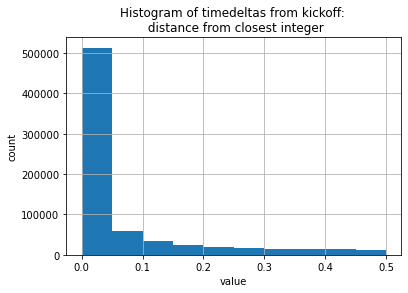

In [320]:
abs(round(timedelta_from_ko) - timedelta_from_ko).hist()
plt.xlabel('value')
plt.ylabel('count')
plt.title('Histogram of timedeltas from kickoff: \n distance from closest integer')
plt.show();

In [321]:
df['min_from_ko'] = round((df['pt_dt'] - df['kickoff_dt']) / np.timedelta64(1,'m')).astype(int)

In [322]:
df

,event_id,level_1,pt,Unnamed: 0,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt,min_from_ko
0,27428324,0,1430344752247,0.0,False,NaN,NaN,NaN,2015,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506,-3306
1,27428324,1,1430369358991,1.0,False,NaN,NaN,3.35,2015,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506,-2896
2,27428324,2,1430385238699,2.0,False,NaN,1.81,3.35,2015,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506,-2631
3,27428324,3,1430425393638,3.0,False,NaN,2.04,3.35,2015,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506,-1962
4,27428324,4,1430431493610,4.0,False,NaN,2.04,3.45,2015,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506,-1860
...,...,...,...,...,...,...,...,...,...,...,...,...
721321,27637117,1147757,1451510940901,305.0,True,1.01,990.00,120.00,2015,2015-12-30 21:29:00.901,2015-12-30 19:46:01.053,103
721322,27637117,1147758,1451511000960,306.0,True,1.01,990.00,190.00,2015,2015-12-30 21:30:00.960,2015-12-30 19:46:01.053,104
721323,27637117,1147759,1451511240270,307.0,True,1.01,990.00,1000.00,2015,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053,108
721324,27637117,1147760,1451511354482,164.0,True,1.01,990.00,1000.00,2015,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053,110


## minutes without explicit data

Records represent changes in values, so if the odds at a certain minute are the same as the previous minute, there will not be a record.  
As we want data on all minutes, we check for minutes without explicit data and impute.

In [323]:
MINUTES_COVERAGE_FROM_KO = 200

Walk through an example.

In [324]:
event_id = 27428324

In [325]:
df[df['event_id'] == event_id]['min_from_ko'].max()

112

In [326]:
range_min_coverage = range(0, min(MINUTES_COVERAGE_FROM_KO, df[df['event_id'] == event_id]['min_from_ko'].max() + 1))
range_min_coverage

range(0, 113)

In [327]:
missing_minutes = sorted(list(set(range_min_coverage) - set(df[df['event_id'] == event_id]['min_from_ko'])))
missing_minutes

[3, 30, 37, 45, 56, 64, 68, 108]

Code for all the DataFrame.

In [328]:
MINUTES_COVERAGE_FROM_KO = 200

aux_df = pd.DataFrame()

for event_id in df['event_id'].unique():
    range_min_coverage = range(0, min(MINUTES_COVERAGE_FROM_KO, df[df['event_id'] == event_id]['min_from_ko'].max() + 1))
    missing_minutes = sorted(list(set(range_min_coverage) - set(df[df['event_id'] == event_id]['min_from_ko'])))
    if missing_minutes:
        aux_df_current = pd.DataFrame({'event_id': [event_id] * len(missing_minutes),
                                      'min_from_ko': missing_minutes})
        aux_df = pd.concat([aux_df, aux_df_current])

In [329]:
aux_df

,event_id,min_from_ko
0,27428324,3
1,27428324,30
2,27428324,37
3,27428324,45
4,27428324,56
...,...,...
11,27637117,105
12,27637117,106
13,27637117,107
14,27637117,109


In [330]:
df = pd.concat([df, aux_df]).sort_values(['event_id', 'min_from_ko'], ignore_index=True)

Impute (ffill)

In [331]:
df[['in_play', 'ltp_home', 'ltp_away', 'ltp_draw', 'year']] = df.groupby('event_id')[['in_play', 'ltp_home', 'ltp_away', 'ltp_draw', 'year']].transform(lambda x: x.ffill())

Drop duplicates (keep first)

In [332]:
df = df.drop_duplicates(subset=['event_id', 'min_from_ko'])

In [333]:
df = df.drop(columns=['level_1', 'Unnamed: 0'])

In [334]:
df

,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt,min_from_ko
0,27428324,1.430345e+12,False,NaN,NaN,NaN,2015.0,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506,-3306
1,27428324,1.430369e+12,False,NaN,NaN,3.35,2015.0,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506,-2896
2,27428324,1.430385e+12,False,NaN,1.81,3.35,2015.0,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506,-2631
3,27428324,1.430425e+12,False,NaN,2.04,3.35,2015.0,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506,-1962
4,27428324,1.430431e+12,False,NaN,2.04,3.45,2015.0,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506,-1860
...,...,...,...,...,...,...,...,...,...,...
799601,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053,108
799602,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,109
799603,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053,110
799604,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,111


## calculations

In [335]:
df[['prob_home', 'prob_away', 'prob_draw']] = 1 / df[['ltp_home', 'ltp_away', 'ltp_draw']]

In [336]:
df['prob_sum'] = df[['prob_home', 'prob_away', 'prob_draw']].sum(axis=1)

In [337]:
#calculate logodds
df[['logodds_home', 'logodds_away', 'logodds_draw']] = np.log(df[['prob_home', 'prob_away', 'prob_draw']]/(1 - df[['prob_home', 'prob_away', 'prob_draw']]))

In [338]:
df[['logodds_home_diff', 'logodds_away_diff', 'logodds_draw_diff']] = df.groupby('event_id')[['logodds_home', 'logodds_away', 'logodds_draw']].transform(lambda x: x.diff())

In [339]:
df[['abs_logodds_home_diff', 'abs_logodds_away_diff', 'abs_logodds_draw_diff']] = abs(df[['logodds_home_diff', 'logodds_away_diff', 'logodds_draw_diff']])

In [340]:
df

,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt,min_from_ko,...,prob_sum,logodds_home,logodds_away,logodds_draw,logodds_home_diff,logodds_away_diff,logodds_draw_diff,abs_logodds_home_diff,abs_logodds_away_diff,abs_logodds_draw_diff
0,27428324,1.430345e+12,False,NaN,NaN,NaN,2015.0,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506,-3306,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27428324,1.430369e+12,False,NaN,NaN,3.35,2015.0,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506,-2896,...,0.298507,NaN,NaN,-0.854415,NaN,NaN,NaN,NaN,NaN,NaN
2,27428324,1.430385e+12,False,NaN,1.81,3.35,2015.0,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506,-2631,...,0.850994,NaN,0.210721,-0.854415,NaN,NaN,0.000000,NaN,NaN,0.000000
3,27428324,1.430425e+12,False,NaN,2.04,3.35,2015.0,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506,-1962,...,0.788704,NaN,-0.039221,-0.854415,NaN,-0.249942,0.000000,NaN,0.249942,0.000000
4,27428324,1.430431e+12,False,NaN,2.04,3.45,2015.0,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506,-1860,...,0.780051,NaN,-0.039221,-0.896088,NaN,0.000000,-0.041673,NaN,0.000000,0.041673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799601,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053,108,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,-1.665008,0.0,0.000000,1.665008
799602,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,109,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799603,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053,110,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799604,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,111,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000


## sanity check

Exclude observations that do not pass a sanity check.  
The criteria have been established after an exploratory analysis that is not the scope of this notebook.  
- too few observations: might indicate I/O issue, or market open for too little time.  
- early finish: if the market closes before 105(90+15) minutes from kickoff, it probably opened late and the kickoff time is not reliable.  
- implied probabilities/ prices that do not converge to (1, 0, 0) before the market being settled indicate incomplete data.  
- if the `in-play` status of the market is `False` after having being `True`, the odds are not reliably `in-play`.

criterion: too few obs

In [341]:
SANITY_MINIMUM_INPLAY_OBS = 20

group_counts = df[df['min_from_ko'] >= 0].groupby('event_id').size()
valid_groups = group_counts[group_counts >= SANITY_MINIMUM_INPLAY_OBS].index
df = df[df['event_id'].isin(valid_groups)]
df

,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt,min_from_ko,...,prob_sum,logodds_home,logodds_away,logodds_draw,logodds_home_diff,logodds_away_diff,logodds_draw_diff,abs_logodds_home_diff,abs_logodds_away_diff,abs_logodds_draw_diff
0,27428324,1.430345e+12,False,NaN,NaN,NaN,2015.0,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506,-3306,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27428324,1.430369e+12,False,NaN,NaN,3.35,2015.0,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506,-2896,...,0.298507,NaN,NaN,-0.854415,NaN,NaN,NaN,NaN,NaN,NaN
2,27428324,1.430385e+12,False,NaN,1.81,3.35,2015.0,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506,-2631,...,0.850994,NaN,0.210721,-0.854415,NaN,NaN,0.000000,NaN,NaN,0.000000
3,27428324,1.430425e+12,False,NaN,2.04,3.35,2015.0,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506,-1962,...,0.788704,NaN,-0.039221,-0.854415,NaN,-0.249942,0.000000,NaN,0.249942,0.000000
4,27428324,1.430431e+12,False,NaN,2.04,3.45,2015.0,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506,-1860,...,0.780051,NaN,-0.039221,-0.896088,NaN,0.000000,-0.041673,NaN,0.000000,0.041673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799601,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053,108,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,-1.665008,0.0,0.000000,1.665008
799602,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,109,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799603,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053,110,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799604,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,111,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000


criterion: early finish (probably late start)

In [342]:
SANITY_MINIMUM_MATCH_LENGTH = 105

second_largest_min_from_ko = df.groupby('event_id')['min_from_ko'].apply(lambda x: min(x.nlargest(2)))
valid_groups = second_largest_min_from_ko[second_largest_min_from_ko >= SANITY_MINIMUM_MATCH_LENGTH].index
df = df[df['event_id'].isin(valid_groups)]
df

,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt,min_from_ko,...,prob_sum,logodds_home,logodds_away,logodds_draw,logodds_home_diff,logodds_away_diff,logodds_draw_diff,abs_logodds_home_diff,abs_logodds_away_diff,abs_logodds_draw_diff
0,27428324,1.430345e+12,False,NaN,NaN,NaN,2015.0,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506,-3306,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27428324,1.430369e+12,False,NaN,NaN,3.35,2015.0,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506,-2896,...,0.298507,NaN,NaN,-0.854415,NaN,NaN,NaN,NaN,NaN,NaN
2,27428324,1.430385e+12,False,NaN,1.81,3.35,2015.0,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506,-2631,...,0.850994,NaN,0.210721,-0.854415,NaN,NaN,0.000000,NaN,NaN,0.000000
3,27428324,1.430425e+12,False,NaN,2.04,3.35,2015.0,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506,-1962,...,0.788704,NaN,-0.039221,-0.854415,NaN,-0.249942,0.000000,NaN,0.249942,0.000000
4,27428324,1.430431e+12,False,NaN,2.04,3.45,2015.0,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506,-1860,...,0.780051,NaN,-0.039221,-0.896088,NaN,0.000000,-0.041673,NaN,0.000000,0.041673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799601,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053,108,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,-1.665008,0.0,0.000000,1.665008
799602,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,109,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799603,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053,110,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799604,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,111,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000


criterion: prices do not converge

In [343]:
SANITY_SMALLEST_LTP_CEILING = 1.15

In [344]:
smallest_ltp_at_second_largest_min_from_ko = df[df['min_from_ko'] == df['event_id'].apply(lambda x: second_largest_min_from_ko[x])].set_index('event_id')[['ltp_home', 'ltp_away', 'ltp_draw']].min(axis=1)
valid_groups = smallest_ltp_at_second_largest_min_from_ko[smallest_ltp_at_second_largest_min_from_ko <= SANITY_SMALLEST_LTP_CEILING].index
df = df[df['event_id'].isin(valid_groups)]
df

,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt,min_from_ko,...,prob_sum,logodds_home,logodds_away,logodds_draw,logodds_home_diff,logodds_away_diff,logodds_draw_diff,abs_logodds_home_diff,abs_logodds_away_diff,abs_logodds_draw_diff
0,27428324,1.430345e+12,False,NaN,NaN,NaN,2015.0,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506,-3306,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27428324,1.430369e+12,False,NaN,NaN,3.35,2015.0,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506,-2896,...,0.298507,NaN,NaN,-0.854415,NaN,NaN,NaN,NaN,NaN,NaN
2,27428324,1.430385e+12,False,NaN,1.81,3.35,2015.0,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506,-2631,...,0.850994,NaN,0.210721,-0.854415,NaN,NaN,0.000000,NaN,NaN,0.000000
3,27428324,1.430425e+12,False,NaN,2.04,3.35,2015.0,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506,-1962,...,0.788704,NaN,-0.039221,-0.854415,NaN,-0.249942,0.000000,NaN,0.249942,0.000000
4,27428324,1.430431e+12,False,NaN,2.04,3.45,2015.0,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506,-1860,...,0.780051,NaN,-0.039221,-0.896088,NaN,0.000000,-0.041673,NaN,0.000000,0.041673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799601,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053,108,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,-1.665008,0.0,0.000000,1.665008
799602,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,109,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799603,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053,110,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799604,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,111,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000


criterion: in_play is False anytime after it becomes True

In [345]:
df_inplay = df[df['min_from_ko'] >= 0]
invalid_groups = df_inplay[df_inplay['in_play'] == False]['event_id'].unique()
df = df[~df['event_id'].isin(invalid_groups)]
df

,event_id,pt,in_play,ltp_home,ltp_away,ltp_draw,year,pt_dt,kickoff_dt,min_from_ko,...,prob_sum,logodds_home,logodds_away,logodds_draw,logodds_home_diff,logodds_away_diff,logodds_draw_diff,abs_logodds_home_diff,abs_logodds_away_diff,abs_logodds_draw_diff
0,27428324,1.430345e+12,False,NaN,NaN,NaN,2015.0,2015-04-29 21:59:12.247,2015-05-02 05:05:11.506,-3306,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27428324,1.430369e+12,False,NaN,NaN,3.35,2015.0,2015-04-30 04:49:18.991,2015-05-02 05:05:11.506,-2896,...,0.298507,NaN,NaN,-0.854415,NaN,NaN,NaN,NaN,NaN,NaN
2,27428324,1.430385e+12,False,NaN,1.81,3.35,2015.0,2015-04-30 09:13:58.699,2015-05-02 05:05:11.506,-2631,...,0.850994,NaN,0.210721,-0.854415,NaN,NaN,0.000000,NaN,NaN,0.000000
3,27428324,1.430425e+12,False,NaN,2.04,3.35,2015.0,2015-04-30 20:23:13.638,2015-05-02 05:05:11.506,-1962,...,0.788704,NaN,-0.039221,-0.854415,NaN,-0.249942,0.000000,NaN,0.249942,0.000000
4,27428324,1.430431e+12,False,NaN,2.04,3.45,2015.0,2015-04-30 22:04:53.610,2015-05-02 05:05:11.506,-1860,...,0.780051,NaN,-0.039221,-0.896088,NaN,0.000000,-0.041673,NaN,0.000000,0.041673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799601,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:34:00.270,2015-12-30 19:46:01.053,108,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,-1.665008,0.0,0.000000,1.665008
799602,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,109,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799603,27637117,1.451511e+12,True,1.01,990.00,1000.00,2015.0,2015-12-30 21:35:54.482,2015-12-30 19:46:01.053,110,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000
799604,27637117,NaN,True,1.01,990.00,1000.00,2015.0,NaT,NaT,111,...,0.992109,4.60517,-6.896694,-6.906755,0.0,0.000000,0.000000,0.0,0.000000,0.000000


## keep in-play data

In [350]:
df_inplay = df[df['min_from_ko'] >= 0]

## process in bulk

In [378]:
TAIL_SIZE_TO_KEEP = 200
MINUTES_COVERAGE_FROM_KO = 200
SANITY_MINIMUM_INPLAY_OBS = 20
SANITY_MINIMUM_MATCH_LENGTH = 105
SANITY_SMALLEST_LTP_CEILING = 1.15

def process_tabular_data(df):
    # imputation and sort values for using data from more than one file
    df['in_play'] = df.groupby('event_id')['in_play'].transform(lambda x: x.ffill())
    df = df.sort_values(['event_id', 'pt'])
    df = df.groupby(['event_id', 'pt']).mean().reset_index()
    df['in_play'] = df['in_play'] > 0
    df[['ltp_home', 'ltp_away', 'ltp_draw']] = df.groupby('event_id')[['ltp_home', 'ltp_away', 'ltp_draw']].transform(lambda x: x.ffill())
    
    # cap number of records per event to save memory
    df = df.groupby('event_id').apply(lambda x: x.tail(TAIL_SIZE_TO_KEEP)).drop(columns=['event_id']).reset_index()
    
    # kickoff and minutes from kickoff
    df['pt_dt'] = pd.to_datetime(df['pt'], unit='ms')
    kickoff_df = df[df['in_play'] == True].drop_duplicates(subset=['event_id'])
    kickoff_df = kickoff_df.rename(columns={'pt_dt': 'kickoff_dt'})
    df = df.merge(kickoff_df[['event_id', 'kickoff_dt']],
              how='inner',
              left_on='event_id',
              right_on='event_id')
    df['min_from_ko'] = round((df['pt_dt'] - df['kickoff_dt']) / np.timedelta64(1,'m')).astype(int)
    
    # minutes without explicit data
    aux_df = pd.DataFrame()
    for event_id in df['event_id'].unique():
        range_min_coverage = range(0, min(MINUTES_COVERAGE_FROM_KO, df[df['event_id'] == event_id]['min_from_ko'].max() + 1))
        missing_minutes = sorted(list(set(range_min_coverage) - set(df[df['event_id'] == event_id]['min_from_ko'])))
        if missing_minutes:
            aux_df_current = pd.DataFrame({'event_id': [event_id] * len(missing_minutes),
                                          'min_from_ko': missing_minutes})
            aux_df = pd.concat([aux_df, aux_df_current])
    df = pd.concat([df, aux_df]).sort_values(['event_id', 'min_from_ko'], ignore_index=True)
    df[['in_play', 'ltp_home', 'ltp_away', 'ltp_draw', 'year']] = df.groupby('event_id')[['in_play', 'ltp_home', 'ltp_away', 'ltp_draw', 'year']].transform(lambda x: x.ffill())
    df = df.drop_duplicates(subset=['event_id', 'min_from_ko'])
    df = df.drop(columns=['level_1', 'Unnamed: 0'])
    
    # calculations
    df[['prob_home', 'prob_away', 'prob_draw']] = 1 / df[['ltp_home', 'ltp_away', 'ltp_draw']]
    df['prob_sum'] = df[['prob_home', 'prob_away', 'prob_draw']].sum(axis=1)
    df[['logodds_home', 'logodds_away', 'logodds_draw']] = np.log(df[['prob_home', 'prob_away', 'prob_draw']]/(1 - df[['prob_home', 'prob_away', 'prob_draw']]))
    df[['logodds_home_diff', 'logodds_away_diff', 'logodds_draw_diff']] = df.groupby('event_id')[['logodds_home', 'logodds_away', 'logodds_draw']].transform(lambda x: x.diff())
    df[['abs_logodds_home_diff', 'abs_logodds_away_diff', 'abs_logodds_draw_diff']] = abs(df[['logodds_home_diff', 'logodds_away_diff', 'logodds_draw_diff']])
    
    # sanity check
    # number of obs per event
    group_counts = df[df['min_from_ko'] >= 0].groupby('event_id').size()
    valid_groups = group_counts[group_counts >= SANITY_MINIMUM_INPLAY_OBS].index
    df = df[df['event_id'].isin(valid_groups)]
    
    # early finish
    second_largest_min_from_ko = df.groupby('event_id')['min_from_ko'].apply(lambda x: min(x.nlargest(2)))
    valid_groups = second_largest_min_from_ko[second_largest_min_from_ko >= SANITY_MINIMUM_MATCH_LENGTH].index
    df = df[df['event_id'].isin(valid_groups)]
    
    # price convergence
    smallest_ltp_at_second_largest_min_from_ko = df[df['min_from_ko'] == df['event_id'].apply(
        lambda x: second_largest_min_from_ko[x])].set_index('event_id')[['ltp_home', 'ltp_away', 'ltp_draw']].min(axis=1)
    valid_groups = smallest_ltp_at_second_largest_min_from_ko[smallest_ltp_at_second_largest_min_from_ko <= SANITY_SMALLEST_LTP_CEILING].index
    df = df[df['event_id'].isin(valid_groups)]
    
    # in-play status
    df_inplay_before_check = df[df['min_from_ko'] >= 0]
    invalid_groups = df_inplay_before_check[df_inplay_before_check['in_play'] == False]['event_id'].unique()
    df = df[~df['event_id'].isin(invalid_groups)]
    
    # keep in-play data
    df_inplay = df[df['min_from_ko'] >= 0]
    
    return df_inplay

In [380]:
years = relevant_filenames_df['year'].unique()

for year in years:
    print(f'Processing data for year {year}\n...')
    tabular_odds_filepath = f'../data/interim/tabular_odds_{year}.csv'
    df = pd.read_csv(tabular_odds_filepath)
    df_inplay = process_tabular_data(df)
    df_inplay.to_csv(f'../data/interim/processed_tabular_odds_{year}.csv')
    print(f'Exported processed data for year {year}')

Processing data for year 2015
...
Exported processed data for year 2015
Processing data for year 2016
...
Exported processed data for year 2016
Processing data for year 2017
...
Exported processed data for year 2017
Processing data for year 2018
...
Exported processed data for year 2018
Processing data for year 2019
...
Exported processed data for year 2019
Processing data for year 2020
...
Exported processed data for year 2020
